# Averaging Example
Import stream and epoc data into Python using **read_block**  
Plot the average waveform around the epoc event using **epoc_filter**  
Good for Evoked Potential detection
## Housekeeping
Import critial libraries

In [1]:
# special call that tells notebook to keep matlplotlib figures open
%config InlineBackend.close_figures = False

# special call that tells notebook to show matlplotlib figures inline
%matplotlib inline

import matplotlib.pyplot as plt  # standard Python plotting library
import numpy as np  # fundamental package for scientific computing, handles arrays and math

# import the primary functions from the tdt library only
from tdt import read_block, epoc_filter, download_demo_data

## Importing the Data
This example uses our [example data sets](https://www.tdt.com/files/examples/TDTExampleData.zip). To import your own data, replace BLOCK_PATH with the full path to your own data block.

In Synapse, you can find the block path in the database. Go to Menu > History. Find your block, then Right-Click > Copy path to clipboard.

In [2]:
download_demo_data()
BLOCK_PATH = 'data/Algernon-180308-130351'

demo data ready


Set up the varibles for the data you want to extract. We will extract channel 3 from the LFP1 stream data store, created by the Neural Stream Processor gizmo, and use our PulseGen epoc event ('PC0/') as our stimulus onset.

In [3]:
REF_EPOC     = 'PC0/'
STREAM_STORE = 'LFP1'
ARTIFACT     = np.inf       # optionally set an artifact rejection level
CHANNEL      = 3
TRANGE       = [-0.3, 0.8]  # window size [start time relative to epoc onset, window duration]

Now read the specified data from our block into a Python structure.

In [4]:
data = read_block(BLOCK_PATH, evtype=['epocs','scalars','streams'], channel=CHANNEL)

read from t=0s to t=61.23s


## Use epoc_filter to extract data around our epoc event
Using the 't' parameter extracts data only from the time range around our epoc event. For stream events, the chunks of data are stored in a list.

In [5]:
data = epoc_filter(data, 'PC0/', t=TRANGE)

Optionally remove artifacts.

In [6]:
art1 = np.array([np.any(x>ARTIFACT) for x in data.streams[STREAM_STORE].filtered], dtype=bool)
art2 = np.array([np.any(x<-ARTIFACT) for x in data.streams[STREAM_STORE].filtered], dtype=bool)
good = np.logical_not(art1) & np.logical_not(art2)
data.streams[STREAM_STORE].filtered = [data.streams[STREAM_STORE].filtered[i] for i in range(len(good)) if good[i]]
num_artifacts = np.sum(np.logical_not(good))
if num_artifacts == len(art1):
    raise Exception('all waveforms rejected as artifacts')

Applying a time filter to a uniformly sampled signal means that the length of each segment could vary by one sample.  Let's find the minimum length so we can trim the excess off before calculating the mean.


In [7]:
min_length = np.min([len(x) for x in data.streams[STREAM_STORE].filtered])
data.streams[STREAM_STORE].filtered = [x[:min_length] for x in data.streams[STREAM_STORE].filtered]

Find the average signal.

In [8]:
all_signals = np.vstack(data.streams[STREAM_STORE].filtered)
mean_signal = np.mean(all_signals, axis=0)
std_signal = np.std(all_signals, axis=0)

## Ready to plot
Create the time vector.


In [9]:
ts = TRANGE[0] + np.arange(0, min_length) / data.streams[STREAM_STORE].fs

Plot all the signals as gray.

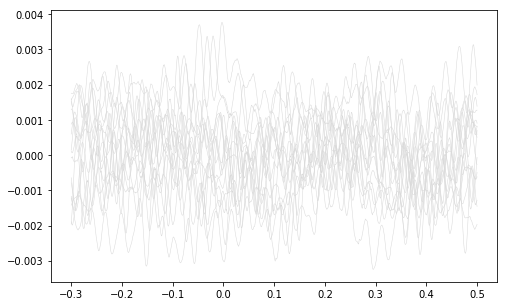

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize=(8,5))
ax1.plot(ts, all_signals.T, color=(.85,.85,.85), linewidth=0.5)
plt.show()

Plot vertical line at time=0.

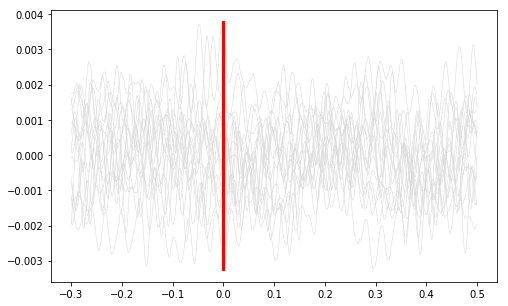

In [11]:
ax1.plot([0, 0], [np.min(all_signals), np.max(all_signals)], color='r', linewidth=3)
plt.show()

Plot the average signal.

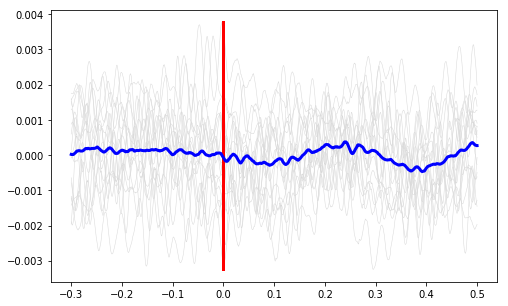

In [12]:
ax1.plot(ts, mean_signal, color='b', linewidth=3)
plt.show()

Plot the standard deviation bands.

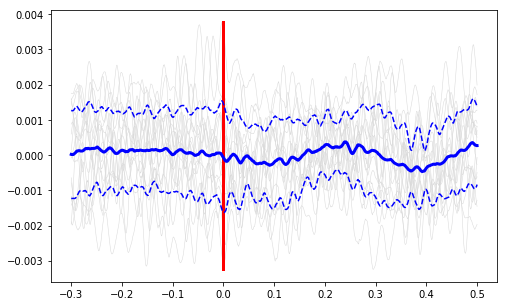

In [13]:
ax1.plot(ts, mean_signal + std_signal, 'b--', ts, mean_signal - std_signal, 'b--')
plt.show()

Finish up the plot

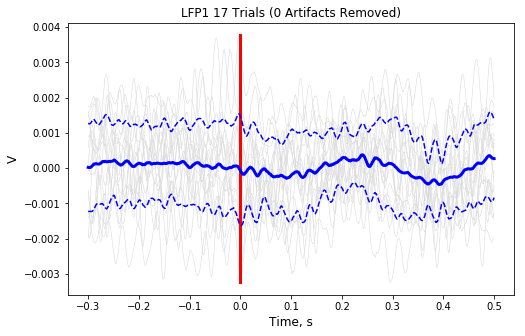

In [14]:
ax1.axis('tight')
ax1.set_xlabel('Time, s',fontsize=12)
ax1.set_ylabel('V',fontsize=12)
ax1.set_title('{0} {1} Trials ({2} Artifacts Removed)'.format(
    STREAM_STORE,
    len(data.streams[STREAM_STORE].filtered),
    num_artifacts))
plt.show()